Author: Sri Sai Charan Velisetti

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from sklearn import mixture
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
import os
import timeit


# Graph-cut Segmentation  

## Overview

Let us apply Graph-cuts for foreground/background segmentation. In the “cat” image, you are given a rough polygon of a foreground cat. Apply graph-cut based method to see if we can get a better segmentation!

Firstly, use the provided polygon to obtain an estimate of foreground and background color likelihood. You may choose the likelihood distribution (e.g., color histograms or color mixture of Gaussians.).

Secondly, apply graph-cut code (cv2.grabcut) to do better segmentation. You can use the provided bounding-boxes and use "cv2 package" for the implementation sake. You are required to draw interesting conclusions on how it performs on different samples.

## Data 

In [ ]:
# Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

## Helper Functions

#### Code 

In [18]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])


time: 1.17 ms (started: 2022-11-24 03:45:03 +00:00)


In [19]:
def mask_for_fg(img, img_mask):
  fg_image = np.zeros_like(img)
  fg_image[img_mask] = img[img_mask]
  return fg_image

def mask_for_bg(img, img_mask):
  bg_image = np.zeros_like(img)
  bg_image[~img_mask] = img[~img_mask]
  return bg_image


def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  original_image = copy.deepcopy(img)
  print( " Orginal Image Shape : ",img.shape)
  original_image = original_image.reshape((-1,3))
  print( " Orginal Image Shape after reshapping : ",original_image.shape)
  log_likelihood_fg = gmm_fg.score_samples(original_image)
  log_likelihood_bg = gmm_bg.score_samples(original_image)

  log_likelihood_fg = log_likelihood_fg.reshape(img.shape[0],img.shape[1]) 
  log_likelihood_bg = log_likelihood_bg.reshape(img.shape[0],img.shape[1]) 
  print("log_likelihood_bg SHAPE :  ", log_likelihood_bg.shape)

  return log_likelihood_fg, log_likelihood_bg

def gaussian_model(img):
  print("Original Image Shape : ", img.shape)
  new_img = img.reshape((-1,3))
  print("New Image Shape : ", new_img.shape)
  gmm_model = mixture.GaussianMixture(n_components= 2,covariance_type="tied").fit(new_img)
  gmm_labels = gmm_model.predict(new_img)

  segmented_image = gmm_labels.reshape(img.shape[0],img.shape[1])
  segmented_image = segmented_image * 255
  print("New Image Shape : ", segmented_image.shape)
  cv2_imshow(segmented_image)
  return gmm_model, gmm_labels

def run_grabcut(img, bbox, itercount):
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  grabcut_mask = np.zeros(img.shape[:2],np.uint8)
  cv2.grabCut(img,grabcut_mask,bbox,bgdModel,fgdModel,itercount,cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((grabcut_mask==2)|(grabcut_mask==0),0,1).astype('uint8')
  img = img*mask2[:,:,np.newaxis]
  show_image(img)
  return None


time: 5.44 ms (started: 2022-11-24 03:45:03 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


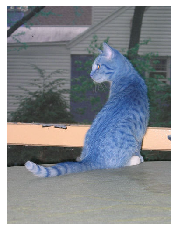

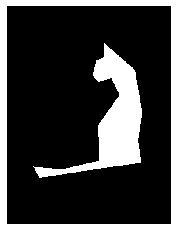

time: 176 ms (started: 2022-11-24 03:45:03 +00:00)


In [20]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img)
show_image(img_mask)

Original Image Shape :  (500, 375, 3)
New Image Shape :  (187500, 3)
New Image Shape :  (500, 375)


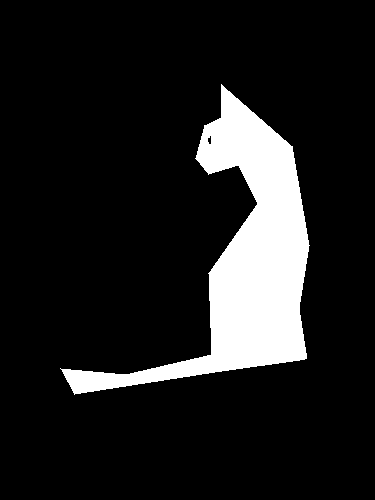

time: 467 ms (started: 2022-11-24 03:45:04 +00:00)


In [21]:
# 1. Fit Gaussian mixture model for foreground regions.

# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(img, img_mask)
gmm_fg, fg_gmm_labels = gaussian_model(fg_image)

Original Image Shape :  (500, 375, 3)
New Image Shape :  (187500, 3)
New Image Shape :  (500, 375)


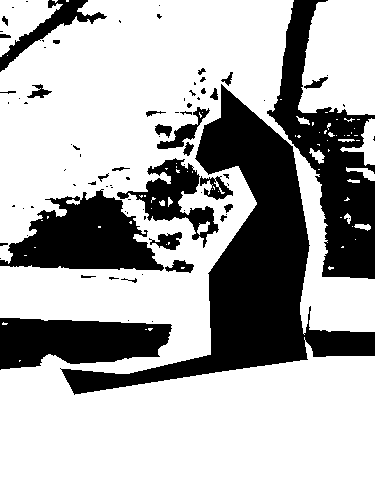

time: 566 ms (started: 2022-11-24 03:45:04 +00:00)


In [22]:
# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(img, img_mask)
gmm_bg, bg_gmm_labels = gaussian_model(bg_image)


 Orginal Image Shape :  (500, 375, 3)
 Orginal Image Shape after reshapping :  (187500, 3)
log_likelihood_bg SHAPE :   (500, 375)
 Foreground 


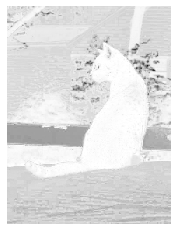

 Background 


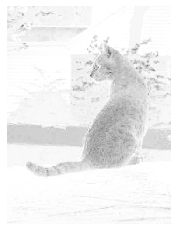

time: 236 ms (started: 2022-11-24 03:45:05 +00:00)


In [23]:
# 3. Compute and visualize the foreground cost and background cost as an image.
# Foreground label cost: -log Pr[Image | foreground model]
# Foreground label cost: -log Pr[Image | background model]

fg,bg = visualize_likelihood_map(gmm_bg, gmm_fg, img)
print(" Foreground ")
show_image(fg)
print(" Background ")
show_image(bg)


  cat  


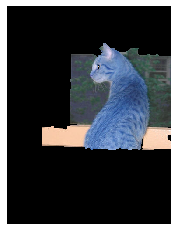

  dog  


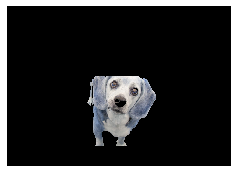

  plane  


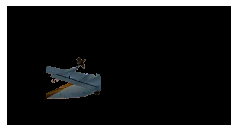

  messi  


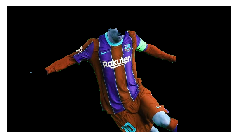

  bird  


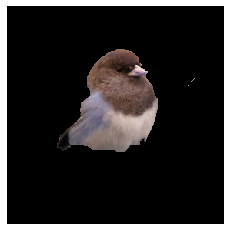

time: 6.11 s (started: 2022-11-24 03:45:05 +00:00)


In [24]:
# 4. Run grabcut algorithm.
img_path = '/content/Part2_GraphCut/'
img = cv2.imread(img_path)
bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}
# bbox = bboxes['dog']
# coord = (250,320,80,80)
for i in bboxes:
  img_path = '/content/Part2_GraphCut/{}.jpg'.format(i)
  img = cv2.imread(img_path)
  # print(img_path)
  print(" " ,i," ")
  run_grabcut(img, bboxes[i],3)

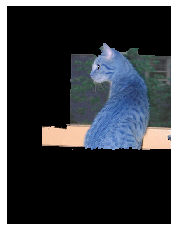

IterCount :  10   . 


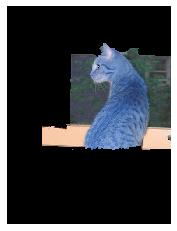

IterCount :  20   . 


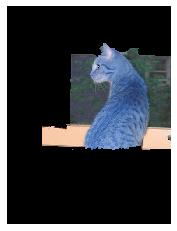

IterCount :  30   . 
time: 10.6 s (started: 2022-11-24 03:45:11 +00:00)


In [25]:
t_bbox = bboxes['cat']
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

for i in (10,20,30):
  run_grabcut(img, t_bbox,i)
  print("IterCount : " , i , "  . ")

### Hints 
- You may refer to https://docs.opencv.org/4.x/dd/dfc/tutorial_js_grabcut.html to implement run_grabcut()